In [72]:
%pylab inline
%matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import pandas as pd
features = pd.read_csv('features.csv', index_col='match_id')

Populating the interactive namespace from numpy and matplotlib
Using matplotlib backend: Qt4Agg


In [73]:
# Utils
import time
import datetime

def barh(labels, values):
    n = len(values)
    f = pylab.figure()
    ax = f.add_axes([0, 0, 1, 1])
    ax.barh(range(n), values, align='center')
    ax.set_yticks(range(n))
    ax.set_yticklabels(labels)
    f.show()

def plot_with_labels(x, y):
    plt.plot(x, y, '-o')
    for i in xrange(len(y)):
        plt.annotate("{0:.3f}".format(y[i]), (x[i], y[i]))
    plt.show()

def measure_time(f):
    def inner(*args, **kwargs):
        start_time = datetime.datetime.now()
        result = f(*args, **kwargs)
        print 'Time elapsed:', datetime.datetime.now() - start_time
        return result
    return inner

## Градиентный бустинг

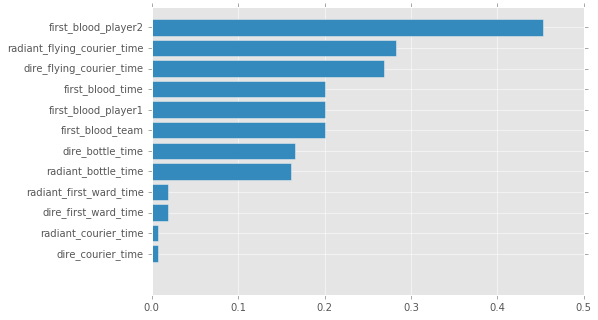

In [74]:
def missing_values_share(df):
    n = float(len(df.index))
    columns = [c for c in df.columns if df[c].count() != n]
    return {column: 1 - df[column].count()/n for column in columns}

missing_features = missing_values_share(features)
barh(*zip(*sorted(missing_features.items(), key=lambda x: x[1])))

In [77]:
features.fillna(value=0, inplace=True)
features.drop(['duration', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'], axis=1, inplace=True)

5 estimators
Time elapsed: 0:00:23.330278
10 estimators
Time elapsed: 0:00:42.083615
15 estimators
Time elapsed: 0:00:58.198124
20 estimators
Time elapsed: 0:01:23.136993
25 estimators
Time elapsed: 0:01:41.140493
30 estimators
Time elapsed: 0:01:54.276882


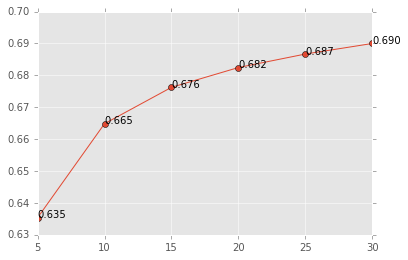

In [79]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

@measure_time
def cross_validation_gradient_boosting(n_estimators, kf, X, y):
    print "{} estimators".format(n_estimators)
    result = []
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = GradientBoostingClassifier(n_estimators=n_estimators, verbose=False)
        clf.fit_transform(X_train, y_train)
        pred = clf.predict_proba(X_test)[:, 1]
        result.append(roc_auc_score(y_test, pred))
    return np.mean(result)

    
def roc_auc_number_of_estimators(df):
    target = 'radiant_win'
    X, y = df[[c for c in df.columns if c != target]].values, df[target].values
    n = len(df.index)
    kf = KFold(n, n_folds=5, shuffle=True, random_state=42)
    n_estimators = range(5, 31, 5)
    roc_aucs = []
    for n in n_estimators:
        roc_aucs.append(cross_validation_gradient_boosting(n, kf, X, y))
    plot_with_labels(n_estimators, roc_aucs)
    
roc_auc_number_of_estimators(features)

# Отчет

1) Какие признаки имеют пропуски среди своих значений (приведите полный список имен этих признаков)? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

Список признаков с пропусками значений: 'first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time', 'dire_first_ward_time'

* 'first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2' - за первые пять минут не произошло событие "первая кровь".
* 'radiant_bottle_time', 'dire_bottle_time' - соответствующая команда не приобрела предмет "bottle" в первые пять минут
* 'radiant_courier_time', 'dire_courier_time' - соответствующая команда не приобрела предмет "courier" в первые пять минут
* 'radiant_flying_courier_time', 'dire_flying_courier_time' - соответствующая команда не приобрела предмет "flying_courier" в первые пять минут 
* 'radiant_first_ward_time', 'dire_first_ward_time' - соответствующая команда не установила наблюдателя в первые пять минут

2) Как называется столбец, содержащий целевую переменную? - *radiant_win*

3) Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Какое качество при этом получилось?

Кросс-валидация проводилась 1:54 минуты, качество 69%.

4) Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

Судя по графику "количество деревьев - качество", максимум не был достигнут и следует продолжать увеличение количества деревьев. Однако чем больше деревьев, тем дольше обучается алгоритм. Несколько способов ускорить обучение на большом количестве деревьев:
* использовать не всю выборку, а её часть
* ограничить глубину дерева (в реализации GradientBoostingClassifier это может быть сделано с помощью аргументов max_depth или max_leaf_nodes)